In [1]:
import sys
sys.path.insert(0, "../")
import numpy as np
from dataset import create_dataset_approx
from structure_compare.compare_pairs import StructureComparePair
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

/home/acowlagi/envs/torch_py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [2]:
train_set, _, _, test_set = create_dataset_approx("cifar10")
x_train, y_train, x_test, y_test = train_set.data/255.0, train_set.targets, test_set.data/255.0, test_set.targets

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/acowlagi/2022-experiments/encoding-structures-of-neural-representations/notebooks/../dataset.py:47: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  data1_list.append(dataset.data[idx][:n1//(d+1)])
/home/acowlagi/2022-experiments/encoding-structures-of-neural-representations/notebooks/../dataset.py:48: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundin

## Deprecated Comparison Scheme

### Computing Distance between Classes (Deprecated)

In [ ]:
class_0_examples, class_1_examples = x_train[y_train == 4], x_train[y_train == 9]
class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
class_1_examples = np.random.randn(*class_1_examples.shape)
class_0_examples = np.random.randn(*class_0_examples.shape)

all_examples = x_train.reshape(x_train.shape[0], -1)

compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.99)


In [ ]:
block_sizes = [1, 10, 40, 100, 200]
distance_scores = []
for block_size in block_sizes:
    curr_block_size_score = []
    for thresh_start in range(0, block_size * (compare_pair.retained_vals // block_size), block_size):
        curr_block_size_score.append(compare_pair.compare_all_coeffs(threshold_start=thresh_start, threshold_end=thresh_start+block_size))

    distance_scores.append((curr_block_size_score, block_size))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for (block_size_dist, block_size) in distance_scores:
    indices = np.arange(start = 0, stop = block_size * (compare_pair.retained_vals // block_size), step = block_size)
    ax.plot(indices, block_size_dist/(np.sqrt(block_size)), label = block_size)
    ax.set_yscale("log")
    break
ax.legend()

### Comparing Projection Coefficients using 2-Sample T-Test (Deprecated)

In [ ]:
from scipy.stats import ttest_ind

max_val = compare_pair.retained_vals
t_stats = []
pvals = []

for ind in range(0, max_val, 5):
    x1_coefficients_ind = compare_pair.x1_proj_coeffs[:, ind]
    x2_coefficients_ind = compare_pair.x2_proj_coeffs[:, ind]
    t_stat, p = ttest_ind(x1_coefficients_ind, x2_coefficients_ind)
    t_stats.append(t_stat)
    pvals.append(p)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.scatter(np.arange(start = 0, stop = max_val, step = 5), np.array(pvals))
# ax.set_xscale("log")

In [ ]:
plt.hist(pvals)

## Comparing Most to Least Representative Class Elements

### Testing Implementation

In [3]:
class_0_examples, class_1_examples = x_train[y_train == 0], x_train[y_train == 1]
class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
# class_1_examples = np.random.randn(*class_1_examples.shape)
# class_0_examples = np.random.randn(*class_0_examples.shape)

all_examples = x_train.reshape(x_train.shape[0], -1)
num_divisions = 8

compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.96, num_divisions = num_divisions, set_all= False, rank_mode= "projection")


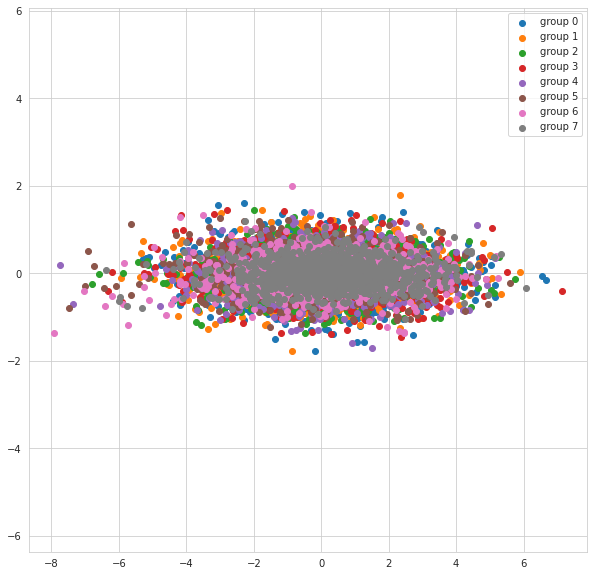

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
for i in range(num_divisions):
    relevant_x1_coeffs = compare_pair.x1_div_coeffs[i]
    relevant_x2_coeffs = compare_pair.x2_div_coeffs[i]
    
    ax.scatter(np.vstack((relevant_x1_coeffs[:, 10], relevant_x2_coeffs[:, 10])), np.vstack((relevant_x1_coeffs[:, 100], relevant_x2_coeffs[:, 100])), label = f"group {i}")
    ax.set_ylim([relevant_x2_coeffs[:, 10].min(), relevant_x2_coeffs[:, 10].max()])
    
ax.legend()

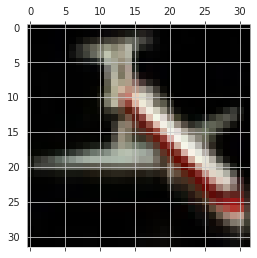

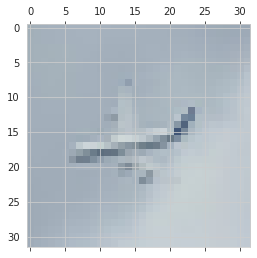

In [5]:
plt.matshow(compare_pair.x1_divided[0][0].reshape(32, 32, 3))
plt.matshow(compare_pair.x1_divided[num_divisions-1][-10].reshape(32, 32, 3))

In [5]:
overlaps = compare_pair.compute_div_overlap(block_size= 20)

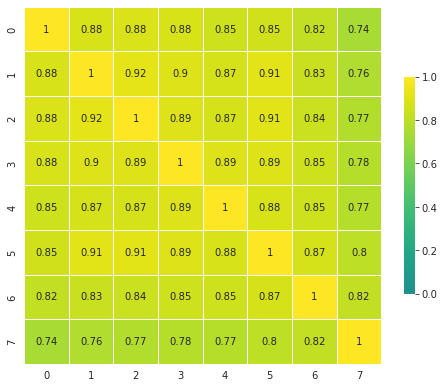

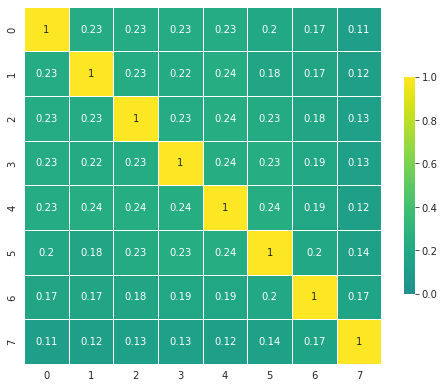

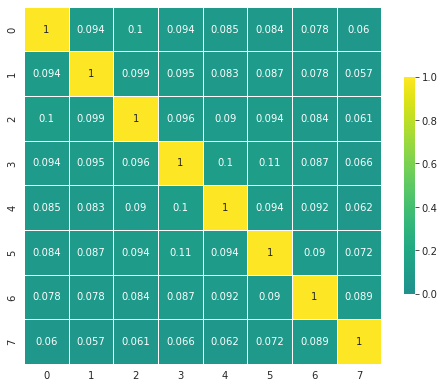

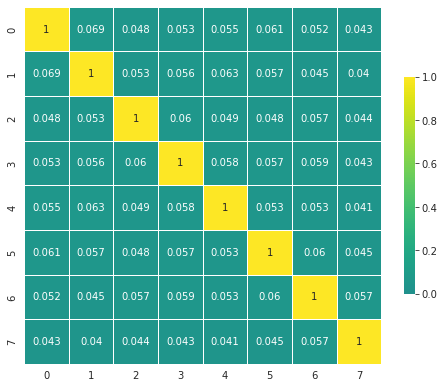

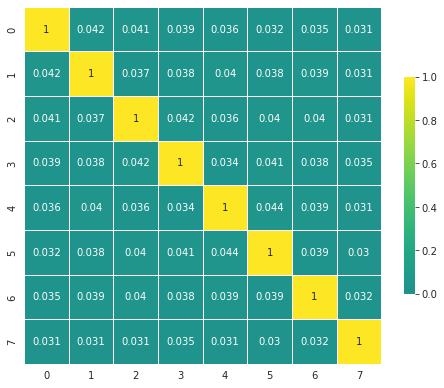

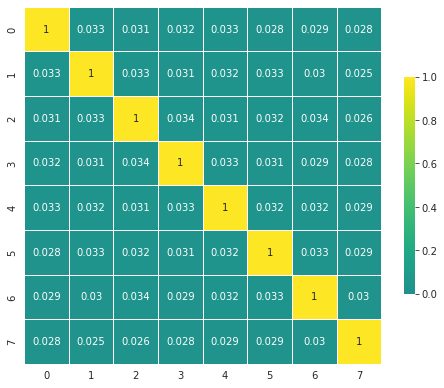

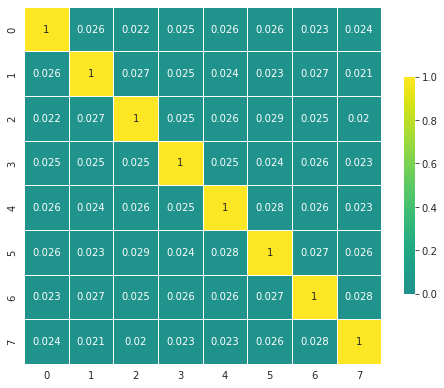

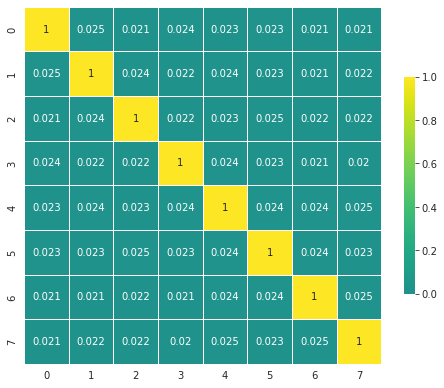

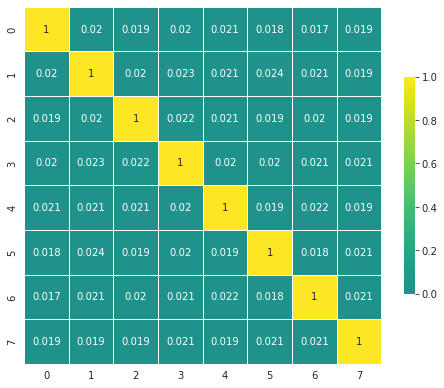

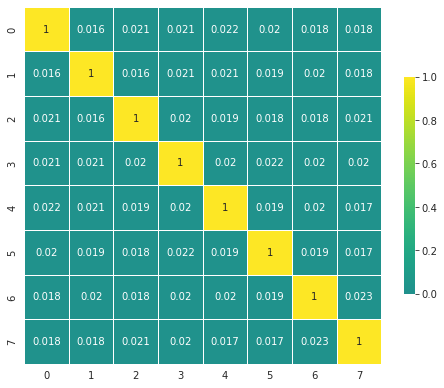

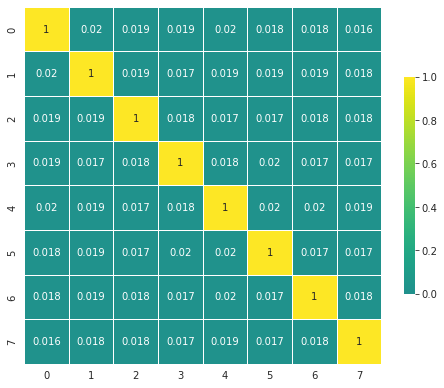

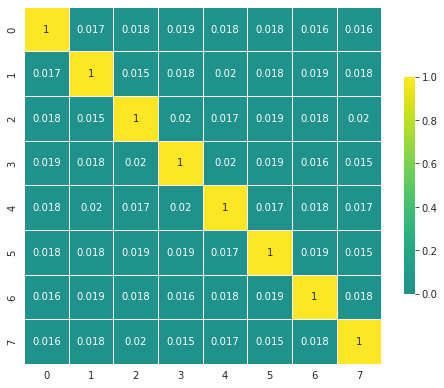

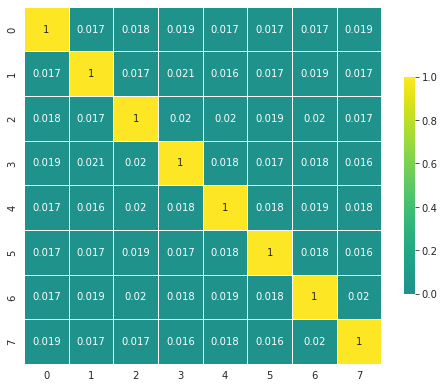

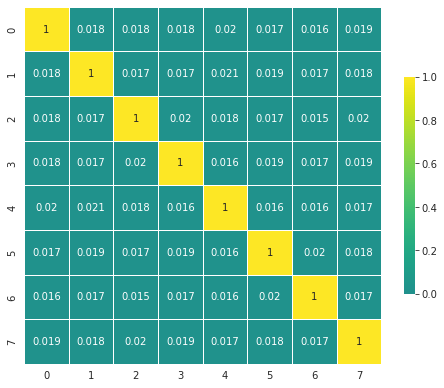

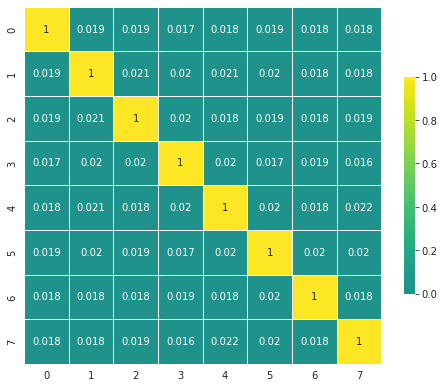

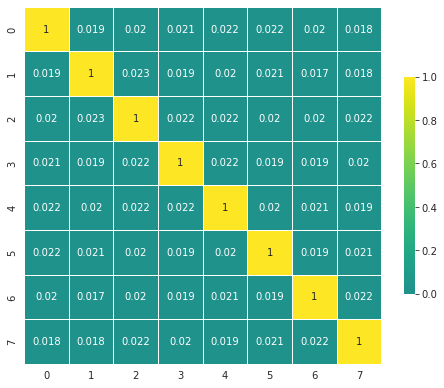

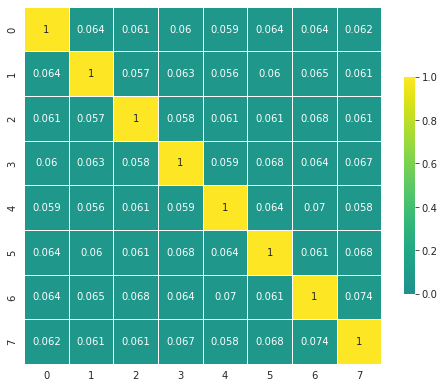

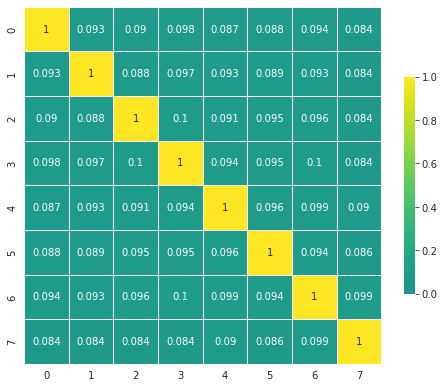

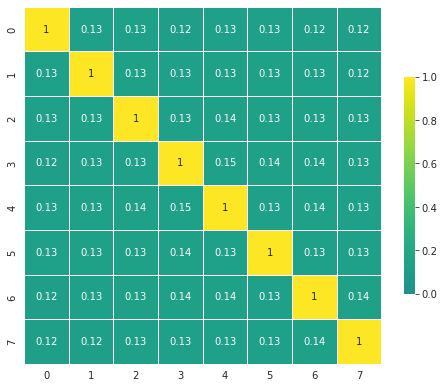

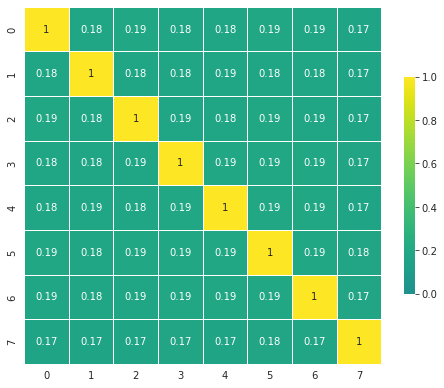

In [6]:
block_correlations = []
num_plots = min(20, overlaps.shape[2])
interval = overlaps.shape[2] // num_plots

for block in range(0, overlaps.shape[2]):
    corr = overlaps[:,:,block] + overlaps[:,:, block].T - np.diag(np.diag(overlaps[:,:,block]))
    if (block % interval) == 0:
        f, ax = plt.subplots(figsize=(8,8))

        sns.heatmap(corr, annot = True, mask=None, vmax=1, vmin = 0, center=0,
                    square=True, linewidths=.5, cmap = "viridis", cbar_kws={"shrink": .5})
        
    block_correlations.append(np.sum(overlaps[:,:,block] - np.diag(np.diag(overlaps[:,:,block])))/(compare_pair.num_divisions*(compare_pair.num_divisions - 1)/2))
    plt.show()

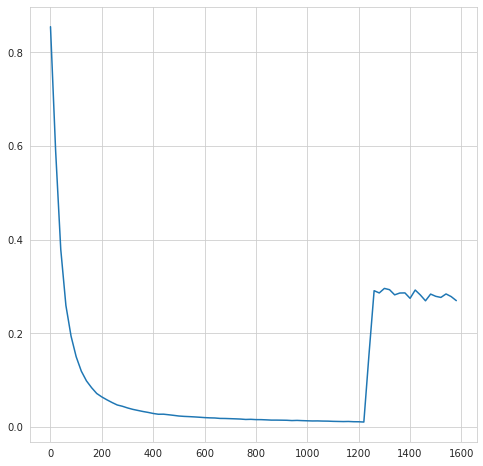

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
ax.plot((compare_pair.div_retained_vals//overlaps.shape[2])*np.arange(0, overlaps.shape[2]), block_correlations)

### Iterating Over (Class 1, Class j) pairs

In [3]:
pair_correlations = []
num_divisions = 8
for i in range(1, 10):
    class_0_examples, class_1_examples = x_train[y_train == 0], x_train[y_train == i]
    class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
    class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
    compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.96, num_divisions = num_divisions, set_all= False, rank_mode= "projection")

    overlaps = compare_pair.compute_div_overlap(block_size= 30)

    block_correlations = []

    for block in range(0, overlaps.shape[2]):
        block_correlations.append(np.sum(overlaps[:,:,block] - np.diag(np.diag(overlaps[:,:,block])))/(compare_pair.num_divisions*(compare_pair.num_divisions - 1)/2))
    
    inds = (compare_pair.div_retained_vals//overlaps.shape[2])*np.arange(0, overlaps.shape[2])
    pair_correlations.append((inds, block_correlations))
        

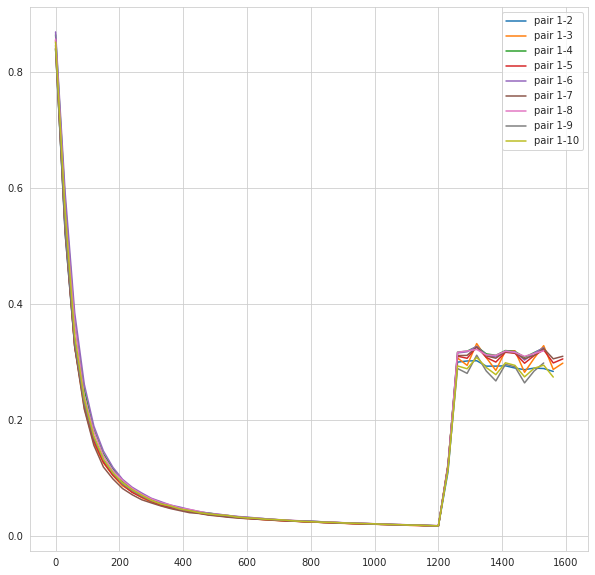

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
i = 1
for (inds, pair_correlation) in pair_correlations:
    i += 1
    ax.plot(inds, pair_correlation, label = f"pair 1-{i}")
    # ax.set_xlim([0, 100])
ax.legend()

## Task Comparison

In [4]:
task_0_examples, task_1_examples = x_train[np.logical_or(y_train == 0,y_train == 1) != 0], x_train[np.logical_or(y_train == 2,y_train == 3) != 0]
task_0_examples = task_0_examples.reshape(task_0_examples.shape[0], -1)
task_1_examples = task_1_examples.reshape(task_1_examples.shape[0], -1)
# class_1_examples = np.random.randn(*class_1_examples.shape)
# class_0_examples = np.random.randn(*class_0_examples.shape)

all_examples = x_train.reshape(x_train.shape[0], -1)
num_divisions = 8

compare_pair = StructureComparePair(x1= task_0_examples, x2= task_1_examples, retain_var= 0.96, num_divisions = None, set_all= False, rank_mode= "projection")


In [5]:
block_size = 20
overlaps = compare_pair.compute_class_overlap(block_size = 20)

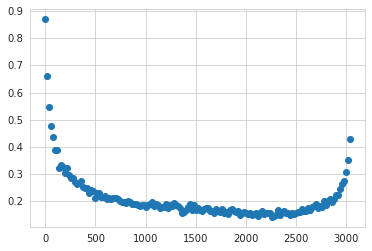

In [6]:
plt.scatter(block_size*np.arange(0, overlaps[0:].shape[0]), overlaps[0:])

In [68]:
compare_pair.s2_proj[:120].sum()/compare_pair.s1_proj.sum()

0.4077044453251638